In [315]:
import ccxt
import os
import math

from dotenv import dotenv_values, load_dotenv
from pprint import pprint
from arch import arch_model

# import ccxt.async_support as ccxt # link against the asynchronous version of ccxt

from functions.BS_pricer import BS_pricer
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process

import numpy as np
import pandas as pd
import scipy as scp
import datetime as dt

# Set the float_format to limit the number of decimal places to 3
pd.options.display.float_format = '{:,.3f}'.format

import scipy.stats as ss
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Load environment variables from .env file
load_dotenv()

"""
# Set the API keys for the exchanges
delta_api_key = os.getenv('DELTA_API_KEY')
delta_api_secret = os.getenv('DELTA_API_SECRET')
deribit_api_key = os.getenv('DERIBIT_API_KEY')
deribit_api_secret = os.getenv('DERIBIT_API_SECRET')
"""

exchanges_list = [
    "delta",
    "deribit",
    "binance",
    "huobi",
    "okex",
]
exchanges_dict = {}
for exch in exchanges_list:
    exchanges_dict[exch] = getattr(ccxt, exch)({
        'apiKey': os.getenv(f"{exch.upper()}_API_KEY") or None,
        'secret': os.getenv(f"{exch.upper()}_API_SECRET") or None,
    })
"""    
# Create the exchange objects
delta = ccxt.delta({
    'apiKey': delta_api_key,
    'secret': delta_api_secret,
})
deribit = ccxt.deribit({
    'apiKey': deribit_api_key,
    'secret': deribit_api_secret,
})
binance = ccxt.binance({
    'apiKey': binance_api_key,
    'secret': binance_api_secret,
})
huobi = ccxt.huobi({
    'apiKey': huobi_api_key,
    'secret': huobi_api_secret,
})
okex = ccxt.okex({
    'apiKey': okex_api_key,
    'secret': okex_api_secret,
})
# Create the dictionary
exchanges_dict = {'delta': delta, 'deribit': deribit}
pprint(exchanges_dict)
"""

"    \n# Create the exchange objects\ndelta = ccxt.delta({\n    'apiKey': delta_api_key,\n    'secret': delta_api_secret,\n})\nderibit = ccxt.deribit({\n    'apiKey': deribit_api_key,\n    'secret': deribit_api_secret,\n})\nbinance = ccxt.binance({\n    'apiKey': binance_api_key,\n    'secret': binance_api_secret,\n})\nhuobi = ccxt.huobi({\n    'apiKey': huobi_api_key,\n    'secret': huobi_api_secret,\n})\nokex = ccxt.okex({\n    'apiKey': okex_api_key,\n    'secret': okex_api_secret,\n})\n# Create the dictionary\nexchanges_dict = {'delta': delta, 'deribit': deribit}\npprint(exchanges_dict)\n"

In [5]:
def binomial_price(S0, K, T, r, sigma, N=15000, payoff="call"):
    # N number of periods or number of time steps  

    dT = float(T) / N                             # Delta t
    u = np.exp(sigma * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 

    V = np.zeros(N+1)                             # initialize the price vector
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compounded return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
    else:
        V[:] = np.maximum(K-S_T, 0.0)

    for i in range(N-1, -1, -1):
        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
            
    return V[0]


In [4]:
# delta_instruments = exchanges_dict['delta'].fetchMarkets()
# deribit_instruments = exchanges_dict['deribit'].fetchMarkets()
instruments_dict = {k: exchanges_dict[k].fetchMarkets() for k in exchanges_dict}
instruments_dict['delta'] = {d['symbol']: d for d in instruments_dict['delta']}
instruments_dict['deribit'] = {d['symbol']: d for d in instruments_dict['deribit']}
instruments_dict['okex'] = {d['symbol']: d for d in instruments_dict['okex']}

In [ ]:
exchange = "delta"
exchanges_dict[exchange].load_markets()



In [20]:
option_markets = [market for market in exchanges_dict[exchange].markets.values() if market['type'] == 'option' and market['base'] == 'BTC']
option_chains = set(market['symbol'] for market in option_markets)
#for option_chain in option_chains:
#    print(option_chain)

In [ ]:
option_chains

In [321]:
delta_exchange_tickers = exchanges_dict['delta'].fetch_tickers()

In [7]:
option_markets = [market for market in delta_exchange_tickers.values() if "call_options" in market['info']['contract_type'] and market['info']['oi_value_symbol'] == 'BTC']
option_chains = set(market['symbol'] for market in option_markets)

In [127]:
def extract_expiry(symbol):
    expiration_date = None
    try:
        date_str = symbol.split(':')[-3][-6:]
        expiration_date = pd.to_datetime(date_str, format='%y%m%d')

    except:
        date_str = symbol.split('-')[-1]
        expiration_date = pd.to_datetime(date_str, format='%d%m%y')

    if not expiration_date:
        print(symbol)
        raise Exception()
        
    return expiration_date

for i in option_markets:
    i['info']['expiration_date'] = extract_expiry(i['symbol'])


In [93]:
for i in option_markets[:4]:
    x = i
    pass

In [9]:
# Define a function to extract the desired columns from the "info" key
def extract_info(info):
    #pprint(info)
    #print(info['expiration_date'].to_pydatetime().strftime("%Y%m%d")+"125959")
    delta_expiration = dt.datetime.strptime(info['expiration_date'].to_pydatetime().strftime("%y%m%d")+"125959", "%y%m%d%H%M%S")
    delta_timedelta_until_expiration = delta_expiration - dt.datetime.now()
    delta_days_until_expiration = delta_timedelta_until_expiration.total_seconds() / 86400
    return {
        "contract_type": "call" if info["contract_type"] == "call_options" else "put",
        **info["greeks"],
        "mark_price": float(info["mark_price"]),
        "mark_vol": float(info["mark_vol"]),
        "ask_iv": float(info["quotes"]["ask_iv"]),
        "bid_iv": float(info["quotes"]["bid_iv"]),
        "spot_price": float(info["spot_price"]),
        "expiration_date": pd.to_datetime(info['expiration_date']),        
        "days_until_expiration": float(delta_days_until_expiration),
        "strike": float(info['strike_price']),
    }

In [173]:
# Extract the desired columns and set the index to "strike_price"
df = pd.DataFrame({
        "contract_type": [extract_info(row["info"])["contract_type"] for row in option_markets],
        "symbol": [str(row["symbol"]) for row in option_markets],
        **{key: [extract_info(row["info"]).get(key) for row in option_markets] for key in extract_info(option_markets[0]["info"]).keys()},
    },
    index=[float(row["info"]["strike_price"]) for row in option_markets],
)

# Print the resulting DataFrame
df.reset_index(inplace=True)
df

,index,contract_type,symbol,delta,gamma,rho,theta,vega,mark_price,mark_vol,ask_iv,bid_iv,spot_price,expiration_date,days_until_expiration,strike
0,30000,put,BTC/USDT:USDT-230428:30000:P,-0.74418283,0.00005100,-46.93364334,-14.55553589,34.45184465,"6,342.653",0.589,0.622,0.554,"24,514.534",2023-04-28,69.669,"30,000.000"
1,29500,put,BTC/USDT:USDT-230224:29500:P,-0.94069330,0.00004207,-5.14388965,-24.79867903,3.91394966,"5,053.903",0.846,1.022,0.000,"24,514.534",2023-02-24,6.669,"29,500.000"
2,26500,put,BTC/USDT:USDT-230218:26500:P,-0.97568663,0.00005953,-0.48139228,-40.37886549,0.60325742,"1,995.701",0.926,1.301,0.000,"24,514.534",2023-02-18,0.669,"26,500.000"
3,26000,put,BTC/USDT:USDT-230224:26000:P,-0.72163015,0.00014754,-3.57679740,-57.17978663,11.13025334,"1,858.351",0.685,0.723,0.648,"24,514.534",2023-02-24,6.669,"26,000.000"
4,25500,put,BTC/USDT:USDT-230224:25500:P,-0.65510820,0.00016839,-3.20694386,-60.34421376,12.21323871,"1,467.850",0.659,0.688,0.632,"24,514.534",2023-02-24,6.669,"25,500.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,19000,call,BTC/USDT:USDT-230224:19000:C,0.98538535,0.00001257,3.40781775,-8.16953313,1.22797367,"5,530.230",0.887,1.264,0.000,"24,514.534",2023-02-24,6.669,"19,000.000"
418,16000,call,BTC/USDT:USDT-230331:16000:C,0.96413361,0.00001261,17.15412018,-5.91046028,6.53011245,"8,612.334",0.754,0.989,0.609,"24,514.534",2023-03-31,41.669,"16,000.000"
419,27000,put,BTC/USDT:USDT-230303:27000:P,-0.76578224,0.00010191,-8.11189941,-33.74865058,14.55663366,"2,874.071",0.634,0.674,0.593,"24,514.534",2023-03-03,13.669,"27,000.000"
420,24500,call,BTC/USDT:USDT-230303:24500:C,0.52439546,0.00014420,4.40217881,-40.19548150,18.89588316,"1,108.227",0.582,0.593,0.571,"24,514.534",2023-03-03,13.669,"24,500.000"


<Axes: title={'center': 'ImpliedVol Skew'}, xlabel='strike'>

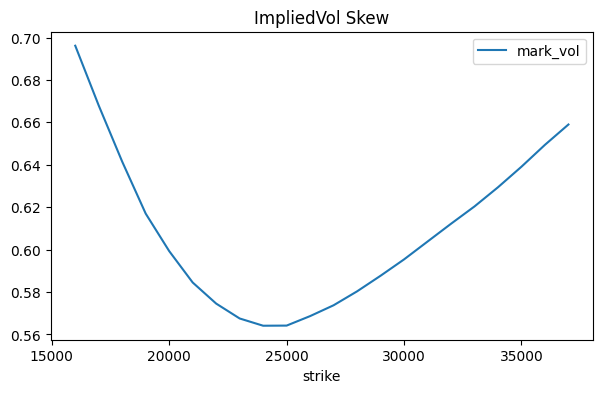

In [143]:
expi = "2023-04-28"
calls_at_expiry = df[df["expiration_date"] == expi]
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.mark_vol >= 0.001]
filtered_calls_at_expiry[['strike','mark_vol']].set_index('strike').sort_index().plot(title="ImpliedVol Skew", figsize=(7,4))

<Axes: title={'center': 'ImpliedVol Term Structure'}, xlabel='expiration_date'>

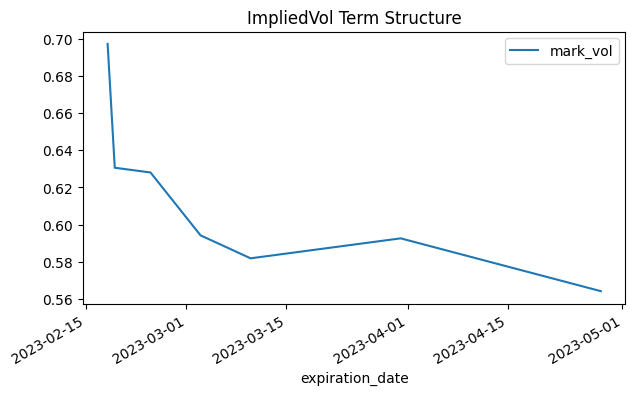

In [144]:
calls_at_expiry = df[df["strike"] == 25000.0]
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.mark_vol >= 0.001]
filtered_calls_at_expiry[['expiration_date', 'mark_vol']].set_index('expiration_date').sort_index().plot(title="ImpliedVol Term Structure", figsize=(7,4))

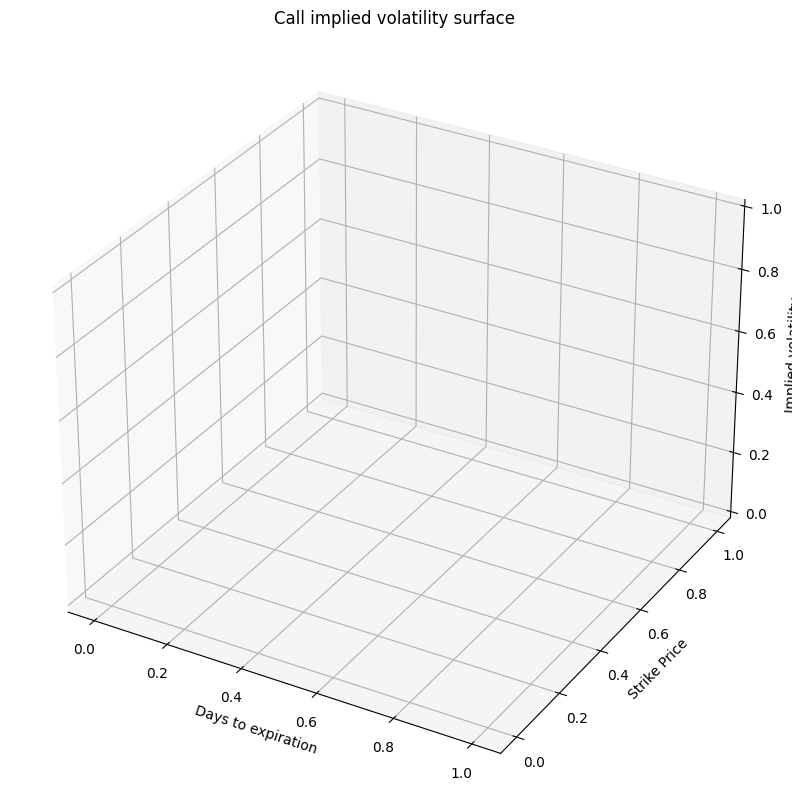

In [149]:
surface = (
    df[["days_until_expiration", "strike", "mark_vol"]]
    .pivot_table(values="mark_vol", index="strike", columns="days_until_expiration")
    .dropna()
)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)

ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

ax.plot_surface(X, Y, z)

In [84]:
import yfinance as yf

test = yf.Ticker('AAPL')
expirations = test.options

In [54]:
call = test.option_chain('2023-03-17').calls

In [341]:
def create_df(exchange_tickers):
    option_markets = [
        market for market in exchange_tickers.values() 
        if "options" in market['info']['contract_type'] and 
        market['info']['oi_value_symbol'] == 'BTC' and
        "move" not in market['info']['contract_type']]
    for i in option_markets: i['info']['expiration_date'] = extract_expiry(i['symbol'])

    df = pd.DataFrame({
            "contract_type": [extract_info(row["info"])["contract_type"] for row in option_markets],
            "symbol": [row["symbol"] for row in option_markets],
            **{key: [extract_info(row["info"]).get(key) for row in option_markets] for key in extract_info(option_markets[0]["info"]).keys()},
        },
        index=[int(row["info"]["strike_price"]) for row in option_markets],
    )

    df.reset_index(inplace=True)
    df['vega'] = df['vega'].astype(float)
    df['rho'] = df['rho'].astype(float)
    df['delta'] = df['delta'].astype(float)
    df['gamma'] = df['gamma'].astype(float)
    df['theta'] = df['theta'].astype(float)
    return df


In [342]:
a = create_df(delta_exchange_tickers)

<Axes: ylabel='Density'>

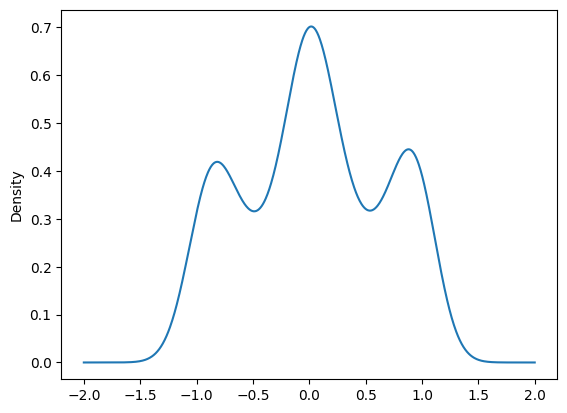

In [363]:
a['delta'].plot.density()

In [365]:
a['delta'].max()

1.0

In [422]:
def isolate_options_type(df, option_type='call'):
    option_chains = df[df['contract_type'] == option_type]
    return option_chains.loc[:,['delta','theta', 'vega', 'days_until_expiration', 'mark_price']]

In [418]:
def normization(df):
    # normalize the input DataFrame
    scaler = MinMaxScaler(feature_range=(-1,1))
    # cols_to_scale = [col for col in df.columns if col != 'delta']
    
    scaled_cols = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_cols, columns=df.columns)
    # df_scaled = pd.concat([df['delta'], df_scaled], axis=1)
    # Scaler formula: X_scaled = (X - X_min) / (X_max - X_min)
    return df_scaled, scaler


In [430]:
def objective(x, weights):
    x.loc[:, 'delta_diff'] = (0.5 - abs(x.loc[:,'delta']))**2
    x.loc[:, 'days_exp'] = x.loc[:, 'days_until_expiration']
    x.loc[:, 'mark_price_div'] = x.loc[:, 'mark_price'].divide(x.loc[:, 'days_exp'])
    x.loc[:, 'vega_div'] = x.loc[:, 'vega'].divide(x.loc[:, 'days_exp'])
    x.loc[:, 'theta_div'] = x.loc[:, 'theta'].divide(x.loc[:, 'days_exp'])
    x_scaled, scaler = normization(x)
    print(f"Scaler max: {scaler.data_max_}\n Scaler min {scaler.data_min_}")
    return x_scaled.loc[:, ['delta_diff', 'mark_price_div', 'theta_div', 'vega_div', 'days_exp']].values.dot(pd.DataFrame(weights).values)

In [432]:
def define_weight(initial_weight):

    weights = np.array(initial_weight)
    print(f"Linear weights: {weights}, test: {np.sum(np.abs(initial_weight))}")

    # Define the decay rate for the exponential weights
    decay_rate = 0.5

    # Calculate the exponential weights
    exp_weights = np.exp(-decay_rate * np.abs(weights))
    exp_weights /= np.sum(exp_weights)

    print(f"Exponential weights: {exp_weights}, decay: {decay_rate}, test: {np.sum(np.abs(exp_weights))}")
    return weights, exp_weights

In [438]:
DEBUG = 1
df = create_df(delta_exchange_tickers)
option_chains = isolate_options_type(df, option_type='put')
if DEBUG: print(option_chains)
#scaled_option_chains, scaler = normization(option_chains)

weights, exp_weights = define_weight(initial_weight=[0.4, 0.2, 0.1, -0.2, -0.1])
if DEBUG: print((weights, exp_weights))
option_chains.loc[:,'score'] = objective(option_chains, weights)
option_chains.sort_values('score', inplace=True)

     delta   theta   vega  days_until_expiration  mark_price
0   -0.728 -27.845 19.033                 19.731   2,865.512
1   -0.998  -2.264  0.063                  0.731   1,948.555
2   -0.665 -56.953 11.310                  5.731   1,233.799
3   -0.944 -37.322  1.281                  0.731     860.747
4   -0.496 -21.471 32.872                 40.731   1,941.770
..     ...     ...    ...                    ...         ...
381 -0.701 -79.574  5.981                  1.731     600.756
382 -0.976 -20.703  0.653                  0.731   1,153.513
385 -0.895 -21.647  8.387                 12.731   4,493.601
386 -0.222 -13.378 31.866                 68.731     898.137
389 -0.774 -32.671 13.877                 12.731   2,692.472

[195 rows x 5 columns]
Linear weights: [ 0.4  0.2  0.1 -0.2 -0.1], test: 1.0000000000000002
Exponential weights: [0.18070078 0.19970525 0.20994436 0.19970525 0.20994436], decay: 0.5, test: 1.0
(array([ 0.4,  0.2,  0.1, -0.2, -0.1]), array([0.18070078, 0.19970525, 0.2

In [446]:
n = 5
candidates_index = option_chains.head(n).index
candidates = df.loc[candidates_index,:]
candidates

,index,contract_type,symbol,delta,gamma,rho,theta,vega,mark_price,mark_vol,ask_iv,bid_iv,spot_price,expiration_date,days_until_expiration,strike
14,24600,put,BTC/USDT:USDT-230219:24600:P,-0.454,0.001,-0.243,-123.554,4.523,167.972,0.423,0.437,0.421,"24,651.450",2023-02-19,0.728,"24,600.000"
12,24700,put,BTC/USDT:USDT-230219:24700:P,-0.535,0.001,-0.287,-126.075,4.536,221.286,0.430,0.443,0.427,"24,651.450",2023-02-19,0.728,"24,700.000"
17,24500,put,BTC/USDT:USDT-230219:24500:P,-0.372,0.001,-0.199,-115.808,4.316,125.717,0.423,0.436,0.404,"24,651.450",2023-02-19,0.728,"24,500.000"
10,24800,put,BTC/USDT:USDT-230219:24800:P,-0.613,0.001,-0.330,-121.940,4.370,281.434,0.434,0.454,0.420,"24,651.450",2023-02-19,0.728,"24,800.000"
21,24400,put,BTC/USDT:USDT-230219:24400:P,-0.298,0.001,-0.160,-108.196,3.959,92.527,0.425,0.442,0.413,"24,651.450",2023-02-19,0.728,"24,400.000"


In [162]:
import requests
import time

def okex_index_current_price():
    url = f"https://www.okx.com/priapi/v5/market/index-tickers?t={int(time.time())}&instId=BTC-USD"
    response = requests.get(url)

    data = response.json()
    return float(data['data'][0]['idxPx'])

In [449]:
for i in candidates['symbol']: print(i)

BTC/USDT:USDT-230219:24600:P
BTC/USDT:USDT-230219:24700:P
BTC/USDT:USDT-230219:24500:P
BTC/USDT:USDT-230219:24800:P
BTC/USDT:USDT-230219:24400:P


In [501]:
def parse_delta(option_string, side='bid'):
    # split the string into components
    components = option_string.split(":")

    # extract the information from the components
    underlying = components[0].split('/')[0]
    quoting_asset = components[1].split("-")[0]
    expiration_date = components[1].split("-")[1]
    strike_price = int(components[2])
    option_type = components[3]

    return {
        "underlying": underlying,
        "quote": quoting_asset,
        "expiration": expiration_date,
        "strike": strike_price,
        "payoff": option_type,
        'side': side,
    }

In [502]:
def extract_contract_specification(candidates):
    contract_specification_list = []
    for i in candidates['symbol']:
        contract_specification_list.append(parse_delta(i))
    
    return contract_specification_list

In [488]:
# We define the contract we are looking for
contract_specification = {
    'expiration': '230220',
    'payoff': 'C',
    'underlying': 'BTC',
    'strike': 25000,
    'quote': 'USDT',
    'side': 'bid',
}

In [489]:
def parse_option_specification_delta(option_specification):
    expiration = dt.datetime.strptime(option_specification['expiration'], "%y%m%d")
    delta_expiration = dt.datetime.strptime(option_specification['expiration']+"125959", "%y%m%d%H%M%S")
    deribit_expiration = dt.datetime.strptime(option_specification['expiration']+"075959", "%y%m%d%H%M%S")
    okex_expiration = dt.datetime.strptime(option_specification['expiration']+"085959", "%y%m%d%H%M%S")
    return {
        "underlying": option_specification['underlying'],
        "quote": option_specification['quote'],
        "expiration": expiration,
        "strike": float(option_specification['strike']),
        "payoff": "call" if option_specification['payoff'] in ("C", "call", "Call", "CALL") else "put",
        "side": "ask" if option_specification['side'] in ("a", "ask", "Ask", "ASK") else "bid",
        "delta_expiration": delta_expiration,
        "deribit_expiration": deribit_expiration,
        "okex_expiration": okex_expiration,
    }

option_specification = parse_option_specification_delta(contract_specification)
pprint(option_specification)

{'delta_expiration': datetime.datetime(2023, 2, 20, 12, 59, 59),
 'deribit_expiration': datetime.datetime(2023, 2, 20, 7, 59, 59),
 'expiration': datetime.datetime(2023, 2, 20, 0, 0),
 'okex_expiration': datetime.datetime(2023, 2, 20, 8, 59, 59),
 'payoff': 'call',
 'quote': 'USDT',
 'side': 'bid',
 'strike': 25000.0,
 'underlying': 'BTC'}


In [514]:
def get_ticker(strike, expiration, underlying, quote, payoff, side):
    # Construct the ticker symbol for the contract
    delta_ticker_specification = f"{underlying}/{quote}:{quote}-{expiration}:{strike}:{payoff}"
    if quote == "USDT": quote = "USD"
    deribit_ticker_specification = f"{underlying}/{quote}:{underlying}-{expiration}-{strike}-{payoff}"
    okex_ticker_specification = f"{underlying}/{quote}:{underlying}-{expiration}-{strike}-{payoff}"

    delta_ticker = None
    deribit_ticker = None
    okex_ticker = None
    # Fetch the ticker data from the Delta exchange
    try:
        delta_ticker = exchanges_dict['delta'].fetch_ticker(delta_ticker_specification)
        #pprint(f"Delta ticker: {delta_ticker}")
    except:
        print(f"No ticker for Delta")

    #'BTC/USD:BTC-230331-50000-P'
    # Fetch the ticker data from the Deribit exchange
    try:
        deribit_ticker = exchanges_dict['deribit'].fetch_ticker(deribit_ticker_specification)
        #pprint(f"Deribit ticker: {deribit_ticker}")
    except:
        print(f"No ticker for deribit")
    try:
        okex_ticker = exchanges_dict['okex'].fetch_ticker(okex_ticker_specification)
        #pprint(f"Okex ticker: {okex_ticker}")
    except:
        print(f"No ticker for Okex")

    return {
        "delta": delta_ticker,
        "deribit": deribit_ticker,
        "okex": okex_ticker,
    }
    
tickers_dict = get_ticker(**contract_specification)

In [515]:
a = [el for el in extract_contract_specification(candidates)]
ticker_dict_list = [get_ticker(**contract_specs) for contract_specs in a]
#ticker_dict_list

No ticker for deribit
No ticker for Okex
No ticker for deribit
No ticker for Okex
No ticker for deribit
No ticker for Okex
No ticker for deribit
No ticker for Okex


In [9]:
now = dt.datetime.now()
forward_date = option_specification["expiration"]

delta_forward_date = option_specification["delta_expiration"]
deribit_forward_date = option_specification["deribit_expiration"]
okex_forward_date = option_specification["okex_expiration"]
print(f"Delta: {(now, delta_forward_date)}")
print(f"Deribit: {(now, deribit_forward_date)}")
print(f"Okex: {(now, okex_forward_date)}")

timedelta_until_expiration = forward_date - now
delta_timedelta_until_expiration = delta_forward_date - now
deribit_timedelta_until_expiration = deribit_forward_date - now
okex_timedelta_until_expiration = okex_forward_date - now

days_until_expiration = timedelta_until_expiration.total_seconds() / 86400
delta_days_until_expiration = delta_timedelta_until_expiration.total_seconds() / 86400
deribit_days_until_expiration = deribit_timedelta_until_expiration.total_seconds() / 86400
okex_days_until_expiration = okex_timedelta_until_expiration.total_seconds() / 86400

print(days_until_expiration)
print(delta_days_until_expiration)
print(deribit_days_until_expiration)
print(okex_days_until_expiration)

Delta: (datetime.datetime(2023, 2, 12, 1, 14, 59, 217008), datetime.datetime(2023, 2, 17, 12, 59, 59))
Deribit: (datetime.datetime(2023, 2, 12, 1, 14, 59, 217008), datetime.datetime(2023, 2, 17, 7, 59, 59))
Okex: (datetime.datetime(2023, 2, 12, 1, 14, 59, 217008), datetime.datetime(2023, 2, 17, 8, 59, 59))
4.947925729074074
5.489580821666666
5.281247488333333
5.322914155


In [10]:
pprint(tickers_dict['delta']['symbol'])

# pprint(instruments_dict['delta'][tickers_dict['delta']['symbol']])
delta_maker_fees_rate = float(instruments_dict['delta'][tickers_dict['delta']['symbol']]['maker'])*100
delta_taker_fees_rate = float(instruments_dict['delta'][tickers_dict['delta']['symbol']]['taker'])*100
delta_premium_commission_rate = float(instruments_dict['delta'][tickers_dict['delta']['symbol']]['info']['product_specs']['premium_commission_rate'])

pprint([
    delta_maker_fees_rate,
    delta_taker_fees_rate,
    delta_premium_commission_rate
])

'BTC/USDT:USDT-230217:21500:C'
[0.03, 0.03, 0.1]


In [11]:
pprint(tickers_dict['deribit']['symbol'])
# pprint(instruments_dict['deribit'][tickers_dict['deribit']['symbol']])

deribit_maker_fees_rate = float(instruments_dict['deribit'][tickers_dict['deribit']['symbol']]['maker'])*100
deribit_taker_fees_rate = float(instruments_dict['deribit'][tickers_dict['deribit']['symbol']]['taker'])*100
deribit_premium_commission_rate = 0.125

pprint([
    deribit_maker_fees_rate,
    deribit_taker_fees_rate,
    deribit_premium_commission_rate
])

'BTC/USD:BTC-230217-21500-C'
[0.03, 0.03, 0.125]


In [12]:
exchanges_dict['okex'].fees#['BTC/USD:BTC-230217-21500-C']['taker']

{'trading': {'percentage': True, 'taker': 0.0015, 'maker': 0.001},
 'funding': {'withdraw': {}, 'deposit': {}},
 'spot': {'taker': 0.0015, 'maker': 0.001},
 'future': {'taker': 0.0005, 'maker': 0.0002},
 'swap': {'taker': 0.0005, 'maker': 0.0002}}

In [13]:
pprint(tickers_dict['okex']['symbol'])
# pprint(instruments_dict['deribit'][tickers_dict['deribit']['symbol']])

#okex_maker_fees_rate = float(instruments_dict['okex'][tickers_dict['okex']['symbol']]['maker'])
#okex_taker_fees_rate = float(instruments_dict['okex'][tickers_dict['okex']['symbol']]['taker'])
#okex_premium_commission_rate = 0.125
okex_maker_fees_rate = 0.0002
okex_taker_fees_rate = 0.0003
okex_premium_commission_rate = 0.125

pprint([
    okex_maker_fees_rate,
    okex_taker_fees_rate,
    okex_premium_commission_rate
])

'BTC/USD:BTC-230217-21500-C'
[0.0002, 0.0003, 0.125]


In [14]:
"""
try:
    a = exchanges_dict['delta'].fetchFees()
    pprint(f"fetchFees: {a}")
    #b = exchanges_dict['delta'].fetchTradingFee(tickers_dict['delta']['info']['product_id'])
    #pprint(f"fetchFees: {b}")
    #c = exchanges_dict['delta'].fetchTradingFees()
    #pprint(f"fetchFees: {c}")
    # d = exchanges_dict['delta'].fetchTransactionFee()
    # pprint(f"fetchFees: {d}")
    #e = exchanges_dict['delta'].fetchTransactionFees()
    #pprint(f"fetchFees: {e}")
    #a = exchanges_dict['deribit'].fetchFees()
    #pprint(f"fetchFees: {a}")
    b = exchanges_dict['deribit'].fetchTradingFee(tickers_dict['deribit']['info']['instrument_name'])
    pprint(f"fetchFees: {b}")
    c = exchanges_dict['deribit'].fetchTradingFees()
    pprint(f"fetchFees: {c}")
    d = exchanges_dict['deribit'].fetchTransactionFee()
    pprint(f"fetchFees: {d}")
    e = exchanges_dict['deribit'].fetchTransactionFees()
    pprint(f"fetchFees: {e}")
except Exception as e:
    pprint(e)
"""

'\ntry:\n    a = exchanges_dict[\'delta\'].fetchFees()\n    pprint(f"fetchFees: {a}")\n    #b = exchanges_dict[\'delta\'].fetchTradingFee(tickers_dict[\'delta\'][\'info\'][\'product_id\'])\n    #pprint(f"fetchFees: {b}")\n    #c = exchanges_dict[\'delta\'].fetchTradingFees()\n    #pprint(f"fetchFees: {c}")\n    # d = exchanges_dict[\'delta\'].fetchTransactionFee()\n    # pprint(f"fetchFees: {d}")\n    #e = exchanges_dict[\'delta\'].fetchTransactionFees()\n    #pprint(f"fetchFees: {e}")\n    #a = exchanges_dict[\'deribit\'].fetchFees()\n    #pprint(f"fetchFees: {a}")\n    b = exchanges_dict[\'deribit\'].fetchTradingFee(tickers_dict[\'deribit\'][\'info\'][\'instrument_name\'])\n    pprint(f"fetchFees: {b}")\n    c = exchanges_dict[\'deribit\'].fetchTradingFees()\n    pprint(f"fetchFees: {c}")\n    d = exchanges_dict[\'deribit\'].fetchTransactionFee()\n    pprint(f"fetchFees: {d}")\n    e = exchanges_dict[\'deribit\'].fetchTransactionFees()\n    pprint(f"fetchFees: {e}")\nexcept Exception

In [15]:
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
# since = exchange.milliseconds () - 86400000  # -1 day from now
start_date = '2022-01-09T00:00:00Z' # fetch from a certain starting datetime
t_frame = '1d' # 1-day timeframe, usually from 1-minute to 1-week depending on the exchange
symbols = [
    'BTC/USDT:USDT',
    #'ETH/USDT:USDT',
    #'AAVE/USDT:USDT',
    #'BNB/USDT:USDT',
    #'CRV/USDT:USDT',
    #'SNX/USDT:USDT',
    #'LINK/USDT:USDT',
]
exchange_list = ['binance', 'huobi', 'okex']
data_df = pd.DataFrame(None, columns=header).set_index('Timestamp')

for exchange_name, exch in exchanges_dict.items():
    print(exch)
    if exchange_name not in exchange_list: continue
    if not exch.has["fetchOHLCV"]:
        print(f'-'*15+f'{exchange_name} does not support fetching OHLC data. Please use another exchange'+f'-'*15)
        quit()
    if (not hasattr(exch, 'timeframes')) or (t_frame not in exch.timeframes):
        print(f'-'*15+f'The requested timeframe ({t_frame}) is not available from {exchange_name}'+f'-'*15)
        print('Available timeframes are:')
        for key in exch.timeframes.keys(): print('  - ' + key)
        print('-'*80)
        quit()
    exch.load_markets()
    for coin in symbols:
        print(coin)
        since = exch.parse8601(start_date) # fetch from a certain starting datetime
        all_ohlcv = []
        while since < exch.milliseconds():
            coin_ohlcv = exch.fetchOHLCV(coin, t_frame, since)
            if not coin_ohlcv: break
            since = coin_ohlcv[-1][0] + 1 # query the last and add 1 to the number of milliseconds
            all_ohlcv += coin_ohlcv
        df = pd.DataFrame(all_ohlcv, columns=header).set_index('Timestamp')
        df['Symbol'] = coin
        df['Exchange'] = exch
        data_df = pd.concat([data_df, df])
        print(data_df)
        data_df.index /= 1000 #Timestamp is 1000 times bigger than it should be in this case
        data_df['Date'] = pd.to_datetime(data_df.index, unit='s')
        data_df.to_csv(f"./data/{exch}_{start_date}_{t_frame}")
        data_df = pd.DataFrame()

Delta Exchange
Deribit
Binance
BTC/USDT:USDT
                    Open       High        Low      Close      Volume  \
Timestamp                                                               
1641686400000 41,688.050 42,773.850 41,170.000 41,851.220 223,134.952   
1641772800000 41,851.220 42,219.840 39,610.000 41,801.550 453,644.116   
1641859200000 41,801.550 43,118.000 41,255.000 42,700.680 323,760.691   
1641945600000 42,700.690 44,300.000 42,415.000 43,880.720 281,339.294   
1642032000000 43,880.720 44,396.680 42,301.160 42,534.320 289,289.180   
...                  ...        ...        ...        ...         ...   
1675814400000 23,234.100 23,450.000 22,662.900 22,955.900 383,465.481   
1675900800000 22,955.900 23,007.800 21,684.700 21,793.400 732,295.350   
1675987200000 21,793.300 21,933.800 21,405.000 21,618.600 439,986.497   
1676073600000 21,618.600 21,891.900 21,594.400 21,851.300 189,249.667   
1676160000000 21,851.200 21,874.700 21,827.100 21,841.200   3,933.249   

     

In [16]:
### Delta Exchange BTC Index for Derivative
e_dict = {}
for e in ['Binance', 'Huobi', 'OKX']:
    e_dict[e] = pd.read_csv(f"./data/{e}_{start_date}_{t_frame}", index_col="Date")
    e_dict[e].index = pd.to_datetime(e_dict[e].index).strftime('%Y-%m-%d')

delta_index = pd.DataFrame()
delta_index['price'] = 0.33 * e_dict['Binance']['Close'] + 0.33 * e_dict['OKX']['Close'] + 0.33 * e_dict['Huobi']['Close']  

In [17]:
### Deribit BTC Index for Derivative
deribit_index = pd.read_csv(
    f"./data/2023-02_btc_usd_price_index.csv",
    usecols=['Date', 'Index']
)

deribit_index['Date'] = pd.to_datetime(deribit_index['Date'])
#pd.to_datetime(deribit_index.index)
deribit_index = deribit_index.set_index('Date')
daily_resampled_deribit_index = deribit_index.resample('D').agg({'Index': 'mean'})

In [18]:
### Okex BTC Index for Derivative
def transform_data_structure(data):
    transformed_data = {
        'Date': [],
        'Open': [],
        'High': [],
        'Low': [],
        'Close': [],
    }
    
    for row in data['data']:
        transformed_data['Date'].append(float(row[0]))
        transformed_data['Open'].append(float(row[1]))
        transformed_data['High'].append(float(row[2]))
        transformed_data['Low'].append(float(row[3]))
        transformed_data['Close'].append(float(row[4]))
        
    df = pd.DataFrame(transformed_data)
    return df

import requests

url = "https://www.okex.com/api/v5/market/history-index-candles?instId=BTC-USDT&bar=1D"

response = requests.get(url)
data = response.json()
okex_index = transform_data_structure(data)
okex_index['Date'] = pd.to_datetime(okex_index['Date'], unit='ms')
okex_index = okex_index.set_index('Date')
#daily_resampled_okex_index = okex_index.resample('D').agg({'Index': 'mean'})
daily_resampled_okex_index = okex_index

In [19]:
okex_index

,Open,High,Low,Close
Date,,,,
2023-02-10 16:00:00,"21,653.600","21,793.000","21,478.500","21,736.100"
2023-02-09 16:00:00,"22,608.600","22,621.200","21,539.400","21,653.900"
2023-02-08 16:00:00,"22,872.900","23,037.100","22,368.500","22,608.500"
2023-02-07 16:00:00,"22,913.500","23,439.500","22,834.600","22,873.100"
2023-02-06 16:00:00,"23,038.400","23,148.200","22,646.700","22,913.200"
...,...,...,...,...
2022-11-06 16:00:00,"21,242.800","21,278.500","20,586.400","20,767.300"
2022-11-05 16:00:00,"21,302.200","21,375.100","21,147.600","21,243.000"
2022-11-04 16:00:00,"20,841.800","21,470.200","20,678.600","21,302.600"


In [20]:
# option['underlying']/option['quote']:option['quote']
# Compute the simple returns and multiply by 100 to avoid the scaling warning from arch_model.
# returns = 100 * df[df["Symbol"] == "BTC/USDT:USDT"]["Close"].pct_change().dropna()
delta_index_returns = 100 * delta_index['price'].pct_change().dropna()
deribit_index_returns = 100 * daily_resampled_deribit_index['Index'].pct_change().dropna()
okex_index_returns = 100 * daily_resampled_okex_index['Close'].pct_change().dropna()


delta_am = arch_model(delta_index_returns, vol="GARCH", p=1, o=0, q=1, dist="normal")
deribit_am = arch_model(deribit_index_returns, vol="GARCH", p=1, o=0, q=1, dist="normal")
okex_am = arch_model(okex_index_returns, vol="GARCH", p=1, o=0, q=1, dist="normal")

delta_res = delta_am.fit(update_freq=5)
deribit_res = deribit_am.fit(update_freq=5)
okex_res = okex_am.fit(update_freq=5)

delta_forecast = delta_res.forecast(horizon=int(delta_days_until_expiration)+1, reindex=False)
deribit_forecast = deribit_res.forecast(horizon=int(deribit_days_until_expiration)+1, reindex=False)
okex_forecast = okex_res.forecast(horizon=int(okex_days_until_expiration)+1, reindex=False)

# forecast = res.forecast(horizon=1, reindex=False)
delta_variance_forecast = delta_forecast.variance.iloc[-1][0]
deribit_variance_forecast = deribit_forecast.variance.iloc[-1][0]
okex_variance_forecast = okex_forecast.variance.iloc[-1][0]

delta_volatility_forecast = np.sqrt(delta_variance_forecast)
deribit_volatility_forecast = np.sqrt(deribit_variance_forecast)
okex_volatility_forecast = np.sqrt(okex_variance_forecast)

my_delta_annualized_volatility_forecast = delta_volatility_forecast * np.sqrt(252) / 100
my_deribit_annualized_volatility_forecast = deribit_volatility_forecast * np.sqrt(252) / 100
my_okex_annualized_volatility_forecast = okex_volatility_forecast * np.sqrt(252) / 100

# Cette VOL est issu de la prediction du GARCH a comparer avec les IV de l'Option Wheel 
# et trade le mispricing
print(f"T_FRAME: {t_frame}")
pprint(my_delta_annualized_volatility_forecast)
pprint(my_deribit_annualized_volatility_forecast)
pprint(my_okex_annualized_volatility_forecast)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 950.1886023029883
Optimization terminated successfully    (Exit mode 0)
            Current function value: 950.1876404065925
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     28,   Neg. LLF: 71.58910451759203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 71.5136466320992
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     29,   Neg. LLF: 223.29855315631184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 223.2950411003658
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9
T_FRAME: 1d
0.3379877736268583
0.26961120378430026
0.5481346094200648


In [21]:
def price_range(iv, current_price, day_to_expiration):
    range_delta = float(current_price*iv*math.sqrt(day_to_expiration/365))
    return [round(current_price - range_delta,3), round(current_price + range_delta,3)]
### JUST AN EXAMPLE
price_range(my_delta_annualized_volatility_forecast, option_specification['strike'], days_until_expiration)

[20653.933, 22346.067]

In [22]:
exchanges_option_contract = {}
### DeltaExchange Format
"""
    Retrieve
    IV
    index price (Underlying price)
    days until expiration
    strike price
    interest rate
    dividend yield (0)
"""
delta_option_contract = tickers_dict['delta']
greeks = delta_option_contract["info"]["greeks"]
ask_iv = float(delta_option_contract["info"]["quotes"]['ask_iv'])
ask_size = float(delta_option_contract["info"]["quotes"]['ask_size'])
best_ask = float(delta_option_contract["info"]["quotes"]['best_ask'])
best_bid = float(delta_option_contract["info"]["quotes"]['best_bid'])
bid_iv = float(delta_option_contract["info"]["quotes"]['bid_iv'])
bid_size = float(delta_option_contract["info"]["quotes"]['bid_size'])
mark_iv = float(delta_option_contract["info"]["quotes"]['mark_iv'])
spot_price = float(delta_option_contract["info"]["spot_price"])

exchanges_option_contract.update(
    {
        'delta': {
            'spot_price': spot_price,
            'best_ask': best_ask,
            'ask_iv': ask_iv,
            'best_bid': best_bid,
            'bid_iv': bid_iv,
            'expiration': delta_days_until_expiration,
            'payoff': option_specification['payoff'],
            'my_iv': my_delta_annualized_volatility_forecast,
        }
    }
)

In [23]:
### Deribit Format
deribit_option_contract = tickers_dict['deribit']
greeks = deribit_option_contract["info"]["greeks"] # Deribit format
ask_iv = float(deribit_option_contract['info']['ask_iv']) if float(deribit_option_contract['info']['ask_iv']) else float(deribit_option_contract['info']['mark_iv']) 
strike_price = option_specification['strike']
spot_price = float(deribit_option_contract["info"]["underlying_price"])
best_ask_price = float(deribit_option_contract["info"]['best_ask_price']) if float(deribit_option_contract['info']['best_ask_price']) else float(deribit_option_contract['info']['mark_price']) 
best_bid_price = float(deribit_option_contract["info"]['best_bid_price']) if float(deribit_option_contract['info']['best_bid_price']) else float(deribit_option_contract['info']['mark_price']) 
bid_iv = float(deribit_option_contract['info']['bid_iv']) if float(deribit_option_contract['info']['bid_iv']) else float(deribit_option_contract['info']['mark_iv']) 

exchanges_option_contract.update(
    {
        'deribit': {
            'spot_price': spot_price,
            'best_ask': best_ask_price*spot_price,
            'ask_iv': ask_iv/100.0,
            'best_bid': best_bid_price*spot_price,
            'bid_iv': bid_iv/100.0, 
            'expiration': deribit_days_until_expiration,   
            'payoff': option_specification['payoff'],  
            'my_iv': my_deribit_annualized_volatility_forecast,   
        }
    }
)

In [50]:
### Okex Format
okex_option_contract = tickers_dict['okex']
#greeks = okex_option_contract["info"] # No greeks on Okex
strike_price = option_specification['strike']
spot_price = okex_index_current_price()
#spot_price = float(okex_option_contract["info"]["underlying_price"])

best_ask_price = float(okex_option_contract['ask'])
best_bid_price = float(okex_option_contract['bid'])

# ask_iv = float(okex_option_contract['info']['ask_iv']) if float(okex_option_contract['info']['ask_iv']) else float(okex_option_contract['info']['mark_iv']) 
# bid_iv = float(okex_option_contract['info']['bid_iv']) if float(okex_option_contract['info']['bid_iv']) else float(okex_option_contract['info']['mark_iv']) 
from trying import implied_volatility_call

ask_iv = implied_volatility_call(
    C=float(best_ask_price*spot_price), 
    S=float(spot_price), 
    K=float(strike_price), 
    T=float(okex_days_until_expiration/365), 
    r=float(1/100),
    max_iterations=100,
)
bid_iv = implied_volatility_call(
    C=float(best_bid_price*spot_price), 
    S=float(spot_price), 
    K=float(strike_price), 
    T=float(okex_days_until_expiration/365), 
    r=float(1/100),
    max_iterations=100,
)
exchanges_option_contract.update(
    {
        'okex': {
            'spot_price': spot_price,
            'best_ask': best_ask_price*spot_price,
            'ask_iv': ask_iv,
            'bid_iv': bid_iv, 
            'best_bid': best_bid_price*spot_price,
            'expiration': okex_days_until_expiration,   
            'payoff': option_specification['payoff'],  
            'my_iv': my_okex_annualized_volatility_forecast,   
        }
    }
)

found on 5th iteration
difference is equal to -5.65886482490896e-05
found on 6th iteration
difference is equal to -6.1846409380450496e-06


In [51]:
exchanges_option_contract['okex']

{'spot_price': 21844.4,
 'best_ask': 688.0986,
 'ask_iv': 0.47424231213519963,
 'bid_iv': 0.40852439139176966,
 'best_bid': 622.5654000000001,
 'expiration': 5.322914155,
 'payoff': 'call',
 'my_iv': 0.5481346094200648}

In [52]:
for exch, option  in exchanges_option_contract.items():
   print((exch, option))

('delta', {'spot_price': 21851.078568185134, 'best_ask': 635.0, 'ask_iv': 0.41239465586841106, 'best_bid': 589.0, 'bid_iv': 0.36642812192440033, 'expiration': 5.489580821666666, 'payoff': 'call', 'my_iv': 0.3379877736268583})
('deribit', {'spot_price': 21855.46, 'best_ask': 644.7360699999999, 'ask_iv': 0.42579999999999996, 'best_bid': 611.9528799999999, 'bid_iv': 0.3926, 'expiration': 5.281247488333333, 'payoff': 'call', 'my_iv': 0.26961120378430026})
('okex', {'spot_price': 21844.4, 'best_ask': 688.0986, 'ask_iv': 0.47424231213519963, 'bid_iv': 0.40852439139176966, 'best_bid': 622.5654000000001, 'expiration': 5.322914155, 'payoff': 'call', 'my_iv': 0.5481346094200648})


In [53]:
pprint(f"Result for {contract_specification}")

for exch, option  in exchanges_option_contract.items():
   # print((exch, option))
   print(f"{'='*20} {exch.upper()} SIDE IS {contract_specification['side']} {'='*20}")
   if contract_specification["side"] == "ask":
      info = {
         "S0": float(option['spot_price']),
         "K": float(option_specification['strike']),
         "T": float(option['expiration']/365),
         "r": float(1/100),
         "sigma": float(option['ask_iv']),
         "payoff": option_specification["payoff"],
      }
      # pprint(f"{info['sigma']:.03f}")
      # BS CLASSIC WITH IV
      theorical_option_price = BS_pricer.BlackScholes(**info)
      # BS CLASSIC WITH GARCH IV
      my_option_price = BS_pricer.BlackScholes(
         S0=float(option['spot_price']),
         K=float(option_specification['strike']),
         T=float(option['expiration']/365),
         r=float(1/100),
         sigma=float(option['my_iv']),
         payoff=option_specification["payoff"]     
      )
      # pprint(f"{float(my_annualized_volatility_forecast):.03f}")
      # BIN PRICING WITH THEIR IV   
      bin_price = binomial_price(**info)

      # PRINT
      print(f"Theorical price, Their IV: {theorical_option_price:.03f}, {float(option['ask_iv'])*100:.03f}%")
      print(f"Price Range: {price_range(float(option['ask_iv']), float(option['spot_price']), float(option['expiration']/365),)}")
      print(f"GARCH price, My IV: {my_option_price:.03f}, {float(option['my_iv'])*100:.03f}%")
      print(f"Price Range: {price_range(float(option['my_iv']), float(option['spot_price']), float(option['expiration']/365),)}")
      print(f"binomial price: {bin_price:.03f}") 
      print(f"current market price {option['best_ask']:.03f}")
   elif contract_specification["side"] == "bid":
      info = {
         "S0": float(option['spot_price']),
         "K": float(option_specification['strike']),
         "T": float(option['expiration']/365),
         "r": float(1/100),
         "sigma": float(option['bid_iv']),
         "payoff": option_specification["payoff"],
      }
      # pprint(f"{info['sigma']:.03f}")
      # BS CLASSIC WITH IV
      theorical_option_price = BS_pricer.BlackScholes(**info)
      # BS CLASSIC WITH GARCH IV
      my_option_price = BS_pricer.BlackScholes(
         S0=float(option['spot_price']),
         K=float(option_specification['strike']),
         T=float(option['expiration']/365),
         r=float(1/100),
         sigma=float(option['my_iv']),
         payoff=option_specification["payoff"]     
      )
      # pprint(f"{float(my_annualized_volatility_forecast):.03f}")
      # BIN PRICING WITH THEIR IV   
      bin_price = binomial_price(**info)

      # PRINT
      print(f"Theorical price, Their IV: {theorical_option_price:.03f}, {float(option['bid_iv'])*100:.03f}%")
      print(f"Price Range: {price_range(float(option['bid_iv']), float(option['spot_price']), float(option['expiration']/365),)}")
      print(f"GARCH price, My IV: {my_option_price:.03f}, {float(option['my_iv'])*100:.03f}%")
      print(f"Price Range: {price_range(float(option['my_iv']), float(option['spot_price']), float(option['expiration']/365),)}")
      print(f"binomial price: {bin_price:.03f}") 
      print(f"current market price {option['best_bid']:.03f}")   

print(f"="*(42+len(max(list(exchanges_dict.keys())))))

("Result for {'expiration': '230217', 'payoff': 'C', 'underlying': 'BTC', "
 "'strike': 21500, 'quote': 'USDT', 'side': 'bid'}")
==================== DELTA SIDE IS bid ====================
Theorical price, Their IV: 591.109, 36.643%
Price Range: [21799.681, 21902.476]
GARCH price, My IV: 563.046, 33.799%
Price Range: [21803.671, 21898.486]
binomial price: 591.106
current market price 589.000
==================== DERIBIT SIDE IS bid ====================
Theorical price, Their IV: 612.422, 39.260%
Price Range: [21801.436, 21909.484]
GARCH price, My IV: 495.429, 26.961%
Price Range: [21818.36, 21892.56]
binomial price: 612.425
current market price 611.953
==================== OKEX SIDE IS bid ====================
Theorical price, Their IV: 622.565, 40.852%
Price Range: [21787.992, 21900.808]
GARCH price, My IV: 762.633, 54.813%
Price Range: [21768.715, 21920.085]
binomial price: 622.569
current market price 622.565


In [89]:
### DATA RETRIEVE BACKUP

for exch in exchange_list:
    print(exch)
    try:
        exchange = getattr(ccxt, exch)()
    except AttributeError:
        print('-'*36,' ERROR ','-'*35)
        print('Exchange "{}" not found. Please check the exchange is supported.'.format(exch))
        print('-'*80)
        quit()
    if exchange.has["fetchOHLCV"] != True:
        print('-'*36,' ERROR ','-'*35)
        print('{} does not support fetching OHLC data. Please use another exchange'.format(exch))
        print('-'*80)
        quit()
    if (not hasattr(exchange, 'timeframes')) or (t_frame not in exchange.timeframes):
        print('-'*36,' ERROR ','-'*35)
        print('The requested timeframe ({}) is not available from {}\n'.format(t_frame,exch))
        print('Available timeframes are:')
        for key in exchange.timeframes.keys():
            print('  - ' + key)
        print('-'*80)
        quit()
    exchange.load_markets()
    for coin in symbols:
        print(coin)
        since = exchange.parse8601(start_date) # fetch from a certain starting datetime
        all_ohlcv = []
        while since < exchange.milliseconds():
            coin_ohlcv = exchange.fetchOHLCV(coin, t_frame, since)
            if not coin_ohlcv: break
            since = coin_ohlcv[-1][0] + 1 # query the last and add 1 to the number of milliseconds
            all_ohlcv += coin_ohlcv
        df = pd.DataFrame(all_ohlcv, columns=header).set_index('Timestamp')
        df['Symbol'] = coin
        df['Exchange'] = exch
        data_df = pd.concat([data_df, df])

data_df.index /= 1000 #Timestamp is 1000 times bigger than it should be in this case
data_df['Date'] = pd.to_datetime(data_df.index, unit='s')
data_df.to_csv(f"./data/{start_date}_{t_frame}")

binance
BTC/USDT:USDT
huobi
BTC/USDT:USDT
okex
BTC/USDT:USDT
